# <center><span style="color:#ff0000"><u>Produisez une Étude de Marché avec Python</u></span></center>
## <center><span style="color:#ff0000"><u>La Poule Qui Chante</u></span></center>

# <u>II - Clusterings, et visualisations associées</u>

## Objectif :

Phase I - un notebook contenant la préparation, le nettoyage et l’analyse exploratoire des données ;

Phase II - un notebook contenant le/les clusterings effectués, et les différentes visualisations associées ;

° une présentation qui récapitule les points suivants : 
    le contexte du projet de data analyse ;
        votre démarche (sans entrer dans les détails mathématiques, mais en vulgarisant les sujets abordés) ;
            vos résultats et recommandations.

In [1]:
#!pip install --upgrade kneed
#!pip install openpyxl
#!pip install xlwt
#!pip install mplcursors

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import folium.plugins as plugins
import os
import mplcursors
import folium
import sys
%matplotlib inline
from seaborn import pairplot, heatmap
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import pearsonr
from plotly.offline import iplot
from kneed import KneeLocator
from collections import Counter
from geopy.geocoders import Nominatim

In [3]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [4]:
warnings.filterwarnings("ignore")
#warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# fonction pour ebouli des valeurs propres : 
def display_scree_eigenvalues(pca):
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rang axe d'inertie")
    plt.ylabel("% inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [6]:
df = pd.read_csv("dispo_pop.csv")
df

Pays  Disponibilite alimentaire  \
0              Afghanistan                       1.53   
1           Afrique du Sud                      35.69   
2                  Albanie                      16.36   
3                  Algérie                       6.38   
4                Allemagne                      19.47   
..                     ...                        ...   
164    Émirats arabes unis                      43.47   
165               Équateur                      19.31   
166  États-Unis d'Amérique                      55.68   
167               Éthiopie                       0.13   
168           Îles Salomon                       4.45   

     Disponibilite interieur  Exportation  Importation  Production  \
0                       57.0          0.0         29.0        28.0   
1                     2118.0         63.0        514.0      1667.0   
2                       47.0          0.0         38.0        13.0   
3                      277.0          0.0          2.0       275.0   
4                     1739.0        646.0        842.0      1514.0   
..                       ...          ...          ...         ...   
164                    412.0         94.0        433.0        48.0   
165                    341.0          0.0          0.0       340.0   
166                  18266.0       3692.0        123.0     21914.0   
167                     14.0          0.0          1.0        14.0   
168                      3.0          0.0          6.0         0.0   

     Variation de stock    pop2007    pop2017  Tx evo_pop  Tx import  Tx prod  
0                   0.0   27100536   36296113        0.03       0.51     0.49  
1                   0.0   49119759   57009756        0.02       0.24     0.79  
2                   4.0    3033998    2884169       -0.01       0.81     0.28  
3                   0.0   34166972   41389189        0.02       0.01     0.99  
4                 -29.0   81277830   82658409        0.00       0.48     0.87  
..                  ...        ...        ...         ...        ...      ...  
164               -26.0    6168838    9487203        0.04       1.05     0.12  
165                -1.0   14296557   16785361        0.02       0.00     1.00  
166                80.0  300608429  325084756        0.01       0.01     1.20  
167                 0.0   80674348  106399924        0.03       0.07     1.00  
168                 3.0     492132     636039        0.03       2.00     0.00  

[169 rows x 12 columns]

In [7]:
# Pays en index
df = df.set_index("Pays")
df.head()

Disponibilite alimentaire  Disponibilite interieur  \
Pays                                                                 
Afghanistan                          1.53                     57.0   
Afrique du Sud                      35.69                   2118.0   
Albanie                             16.36                     47.0   
Algérie                              6.38                    277.0   
Allemagne                           19.47                   1739.0   

                Exportation  Importation  Production  Variation de stock  \
Pays                                                                       
Afghanistan             0.0         29.0        28.0                 0.0   
Afrique du Sud         63.0        514.0      1667.0                 0.0   
Albanie                 0.0         38.0        13.0                 4.0   
Algérie                 0.0          2.0       275.0                 0.0   
Allemagne             646.0        842.0      1514.0               -29.0   

                 pop2007   pop2017  Tx evo_pop  Tx import  Tx prod  
Pays                                                                
Afghanistan     27100536  36296113        0.03       0.51     0.49  
Afrique du Sud  49119759  57009756        0.02       0.24     0.79  
Albanie          3033998   2884169       -0.01       0.81     0.28  
Algérie         34166972  41389189        0.02       0.01     0.99  
Allemagne       81277830  82658409        0.00       0.48     0.87

In [8]:
df.tail()

Disponibilite alimentaire  Disponibilite interieur  \
Pays                                                                        
Émirats arabes unis                        43.47                    412.0   
Équateur                                   19.31                    341.0   
États-Unis d'Amérique                      55.68                  18266.0   
Éthiopie                                    0.13                     14.0   
Îles Salomon                                4.45                      3.0   

                       Exportation  Importation  Production  \
Pays                                                          
Émirats arabes unis           94.0        433.0        48.0   
Équateur                       0.0          0.0       340.0   
États-Unis d'Amérique       3692.0        123.0     21914.0   
Éthiopie                       0.0          1.0        14.0   
Îles Salomon                   0.0          6.0         0.0   

                       Variation de stock    pop2007    pop2017  Tx evo_pop  \
Pays                                                                          
Émirats arabes unis                 -26.0    6168838    9487203        0.04   
Équateur                             -1.0   14296557   16785361        0.02   
États-Unis d'Amérique                80.0  300608429  325084756        0.01   
Éthiopie                              0.0   80674348  106399924        0.03   
Îles Salomon                          3.0     492132     636039        0.03   

                       Tx import  Tx prod  
Pays                                       
Émirats arabes unis         1.05     0.12  
Équateur                    0.00     1.00  
États-Unis d'Amérique       0.01     1.20  
Éthiopie                    0.07     1.00  
Îles Salomon                2.00     0.00

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, Afghanistan to Îles Salomon
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Disponibilite alimentaire  169 non-null    float64
 1   Disponibilite interieur    169 non-null    float64
 2   Exportation                169 non-null    float64
 3   Importation                169 non-null    float64
 4   Production                 169 non-null    float64
 5   Variation de stock         169 non-null    float64
 6   pop2007                    169 non-null    int64  
 7   pop2017                    169 non-null    int64  
 8   Tx evo_pop                 169 non-null    float64
 9   Tx import                  169 non-null    float64
 10  Tx prod                    169 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 15.8+ KB


In [10]:
df.describe()

Disponibilite alimentaire  Disponibilite interieur  Exportation  \
count                 169.000000               169.000000   169.000000   
mean                   20.486568               691.254438   105.591716   
std                    15.855777              2193.162277   461.926200   
min                     0.130000                 2.000000     0.000000   
25%                     7.060000                30.000000     0.000000   
50%                    18.270000               102.000000     0.000000   
75%                    30.300000               372.000000    12.000000   
max                    72.310000             18266.000000  4223.000000   

       Importation    Production  Variation de stock       pop2007  \
count   169.000000    169.000000          169.000000  1.690000e+02   
mean     90.047337    720.502959           13.668639  3.844956e+07   
std     187.102175   2494.734846           75.364884  1.414376e+08   
min       0.000000      0.000000         -119.000000  4.777800e+04   
25%       3.000000     13.000000            0.000000  2.504019e+06   
50%      16.000000     69.000000            0.000000  8.724243e+06   
75%      82.000000    392.000000            7.000000  2.518460e+07   
max    1069.000000  21914.000000          859.000000  1.345994e+09   

            pop2017  Tx evo_pop   Tx import     Tx prod  
count  1.690000e+02  169.000000  169.000000  169.000000  
mean   4.313051e+07    0.013905    0.460237    0.769704  
std    1.543968e+08    0.013189    0.519000    0.495978  
min    5.204500e+04   -0.010000    0.000000    0.000000  
25%    2.845414e+06    0.000000    0.040000    0.360000  
50%    9.729823e+06    0.010000    0.250000    0.870000  
75%    2.940248e+07    0.020000    0.810000    1.000000  
max    1.421022e+09    0.060000    3.240000    3.050000

In [11]:
df_acp = df # Pour l'ACP

## <span style="color:#000080">Classification Ascendante Hiérarchique </span>

In [12]:
# Mise à l'échelle des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled2 = scaler.fit_transform(df)

In [13]:
# Calcul de la matrice de liaison hiérarchique
Z = linkage(df_scaled2, method='ward', metric='euclidean') # Z représente la matrice de lien, utilisé pour le dendrogramme

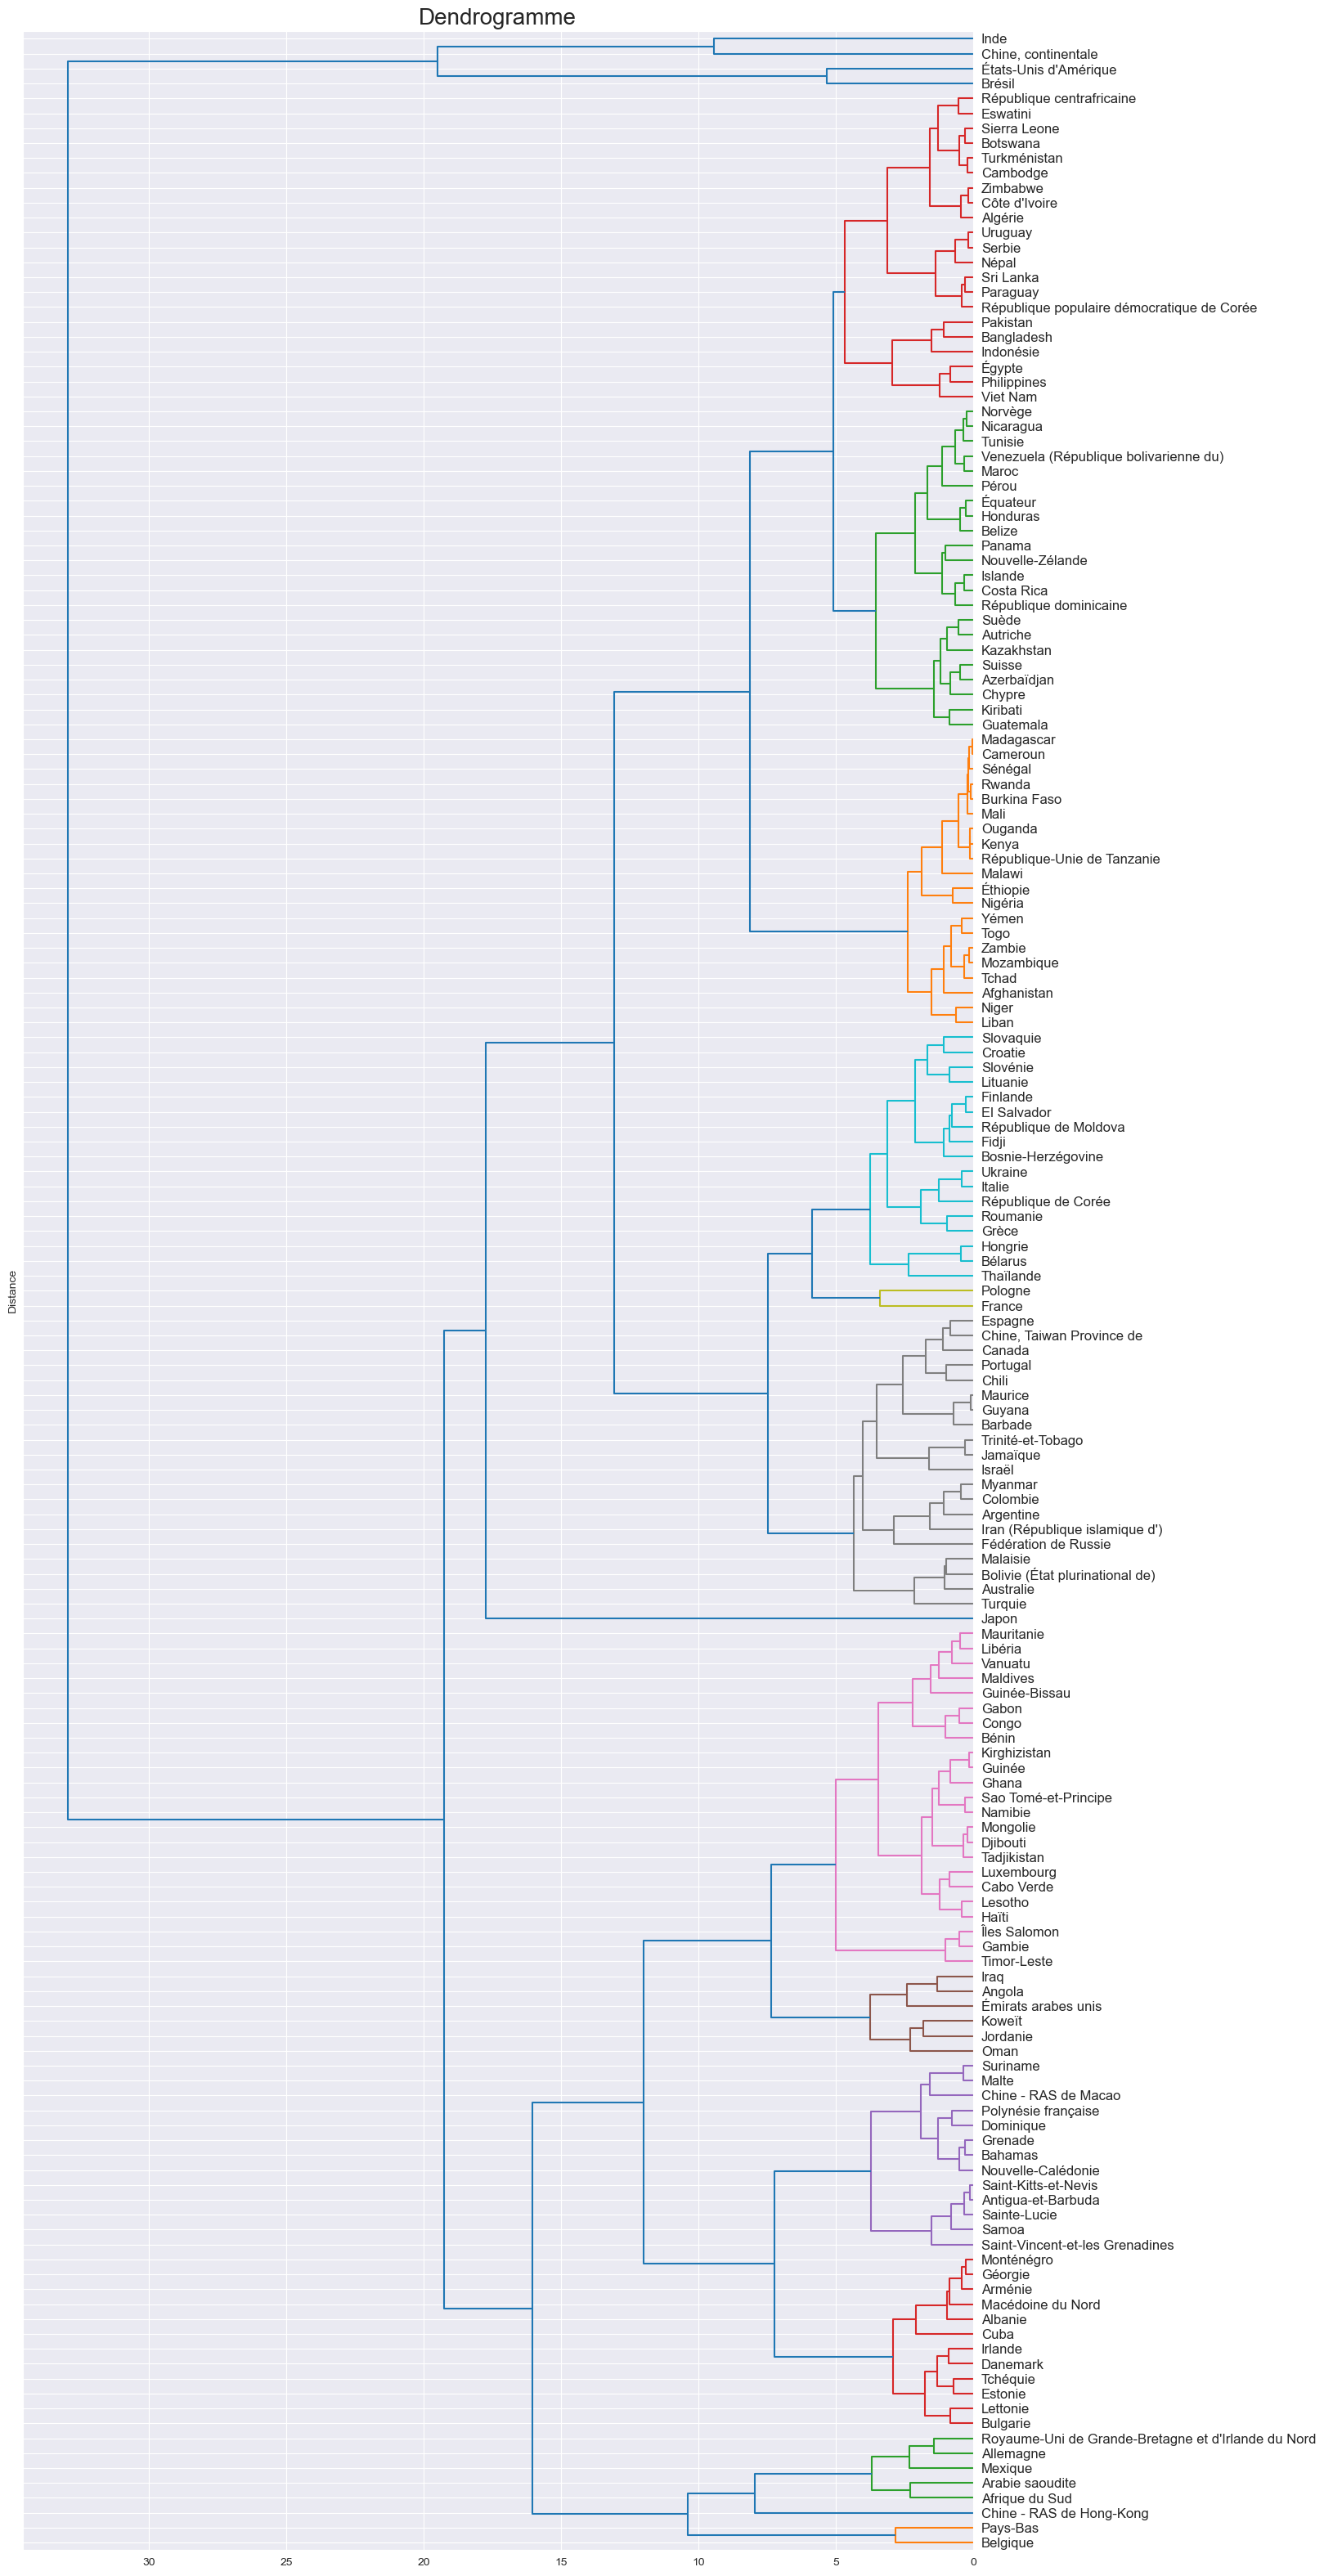

In [14]:
# Tracé du dendrogramme
plt.figure(figsize=(15, 40))
sns.set_style("darkgrid")
plt.title("Dendrogramme", fontsize=20)
plt.ylabel("Distance")
dendrogram(Z, labels=df.index, leaf_font_size=12, color_threshold=5, orientation="left")
plt.savefig("dendrogramv1")
plt.show()

In [15]:
# Réalisation du clustering hierarchique avec fcluster
grp_dendrogram = fcluster(Z, t=10, criterion='distance')
# La valeur t=10 est un seuil utilisé pour couper le dendrogramme et former des clusters

nb_groupes = np.unique(grp_dendrogram).size
print("Il y à", nb_groupes, "groupes de Pays.")

Il y à 9 groupes de Pays.


In [16]:
df["Groupe Pays"] = grp_dendrogram
df

Disponibilite alimentaire  Disponibilite interieur  \
Pays                                                                        
Afghanistan                                 1.53                     57.0   
Afrique du Sud                             35.69                   2118.0   
Albanie                                    16.36                     47.0   
Algérie                                     6.38                    277.0   
Allemagne                                  19.47                   1739.0   
...                                          ...                      ...   
Émirats arabes unis                        43.47                    412.0   
Équateur                                   19.31                    341.0   
États-Unis d'Amérique                      55.68                  18266.0   
Éthiopie                                    0.13                     14.0   
Îles Salomon                                4.45                      3.0   

                       Exportation  Importation  Production  \
Pays                                                          
Afghanistan                    0.0         29.0        28.0   
Afrique du Sud                63.0        514.0      1667.0   
Albanie                        0.0         38.0        13.0   
Algérie                        0.0          2.0       275.0   
Allemagne                    646.0        842.0      1514.0   
...                            ...          ...         ...   
Émirats arabes unis           94.0        433.0        48.0   
Équateur                       0.0          0.0       340.0   
États-Unis d'Amérique       3692.0        123.0     21914.0   
Éthiopie                       0.0          1.0        14.0   
Îles Salomon                   0.0          6.0         0.0   

                       Variation de stock    pop2007    pop2017  Tx evo_pop  \
Pays                                                                          
Afghanistan                           0.0   27100536   36296113        0.03   
Afrique du Sud                        0.0   49119759   57009756        0.02   
Albanie                               4.0    3033998    2884169       -0.01   
Algérie                               0.0   34166972   41389189        0.02   
Allemagne                           -29.0   81277830   82658409        0.00   
...                                   ...        ...        ...         ...   
Émirats arabes unis                 -26.0    6168838    9487203        0.04   
Équateur                             -1.0   14296557   16785361        0.02   
États-Unis d'Amérique                80.0  300608429  325084756        0.01   
Éthiopie                              0.0   80674348  106399924        0.03   
Îles Salomon                          3.0     492132     636039        0.03   

                       Tx import  Tx prod  Groupe Pays  
Pays                                                    
Afghanistan                 0.51     0.49            6  
Afrique du Sud              0.24     0.79            2  
Albanie                     0.81     0.28            3  
Algérie                     0.01     0.99            6  
Allemagne                   0.48     0.87            2  
...                          ...      ...          ...  
Émirats arabes unis         1.05     0.12            4  
Équateur                    0.00     1.00            6  
États-Unis d'Amérique       0.01     1.20            8  
Éthiopie                    0.07     1.00            6  
Îles Salomon                2.00     0.00            4  

[169 rows x 12 columns]

In [17]:
grp_dendrogram = df.groupby(["Groupe Pays"], as_index = False).agg({"mean"})
grp_dendrogram.head(10)

Disponibilite alimentaire Disponibilite interieur  Exportation  \
                                 mean                    mean         mean   
Groupe Pays                                                                  
1                           16.490000              262.000000  1037.000000   
2                           36.081667             2004.166667   291.666667   
3                           34.184000               59.440000    13.840000   
4                           13.229310               98.000000     4.724138   
5                           29.790000              794.717949   124.256410   
6                           10.729206              261.365079     2.968254   
7                           18.500000             2415.000000    10.000000   
8                           51.855000            14124.000000  3957.500000   
9                            7.275000            10911.000000   290.000000   

             Importation    Production Variation de stock       pop2007  \
                    mean          mean               mean          mean   
Groupe Pays                                                               
1             473.000000    781.500000         -44.000000  1.360211e+07   
2             789.333333   1480.666667         -25.833333  5.550798e+07   
3              46.400000     28.560000           1.640000  2.334949e+06   
4              81.275862     21.413793          -0.137931  5.335788e+06   
5              68.871795    891.076923          40.948718  2.624036e+07   
6              26.761905    240.000000           2.365079  2.782224e+07   
7            1069.000000   2215.000000         859.000000  1.284941e+08   
8              63.000000  18057.500000          40.000000  2.453694e+08   
9             226.000000  10890.500000         -84.500000  1.264602e+09   

                  pop2017 Tx evo_pop Tx import   Tx prod  
                     mean       mean      mean      mean  
Groupe Pays                                               
1            1.422055e+07   0.005000  1.925000  3.005000  
2            6.193007e+07   0.013333  0.840000  0.626667  
3            2.350719e+06   0.003600  0.877200  0.302800  
4            7.121837e+06   0.027931  1.048276  0.201034  
5            2.778275e+07   0.003590  0.172308  1.145128  
6            3.365215e+07   0.018730  0.148730  0.900635  
7            1.275027e+08   0.000000  0.440000  0.920000  
8            2.664593e+08   0.010000  0.005000  1.310000  
9            1.379849e+09   0.010000  0.010000  0.985000

In [18]:
df_centroids = df.groupby("Groupe Pays").mean().reset_index()
df_centroids.head(10)

Groupe Pays  Disponibilite alimentaire  Disponibilite interieur  \
0            1                  16.490000               262.000000   
1            2                  36.081667              2004.166667   
2            3                  34.184000                59.440000   
3            4                  13.229310                98.000000   
4            5                  29.790000               794.717949   
5            6                  10.729206               261.365079   
6            7                  18.500000              2415.000000   
7            8                  51.855000             14124.000000   
8            9                   7.275000             10911.000000   

   Exportation  Importation    Production  Variation de stock       pop2007  \
0  1037.000000   473.000000    781.500000          -44.000000  1.360211e+07   
1   291.666667   789.333333   1480.666667          -25.833333  5.550798e+07   
2    13.840000    46.400000     28.560000            1.640000  2.334949e+06   
3     4.724138    81.275862     21.413793           -0.137931  5.335788e+06   
4   124.256410    68.871795    891.076923           40.948718  2.624036e+07   
5     2.968254    26.761905    240.000000            2.365079  2.782224e+07   
6    10.000000  1069.000000   2215.000000          859.000000  1.284941e+08   
7  3957.500000    63.000000  18057.500000           40.000000  2.453694e+08   
8   290.000000   226.000000  10890.500000          -84.500000  1.264602e+09   

        pop2017  Tx evo_pop  Tx import   Tx prod  
0  1.422055e+07    0.005000   1.925000  3.005000  
1  6.193007e+07    0.013333   0.840000  0.626667  
2  2.350719e+06    0.003600   0.877200  0.302800  
3  7.121837e+06    0.027931   1.048276  0.201034  
4  2.778275e+07    0.003590   0.172308  1.145128  
5  3.365215e+07    0.018730   0.148730  0.900635  
6  1.275027e+08    0.000000   0.440000  0.920000  
7  2.664593e+08    0.010000   0.005000  1.310000  
8  1.379849e+09    0.010000   0.010000  0.985000

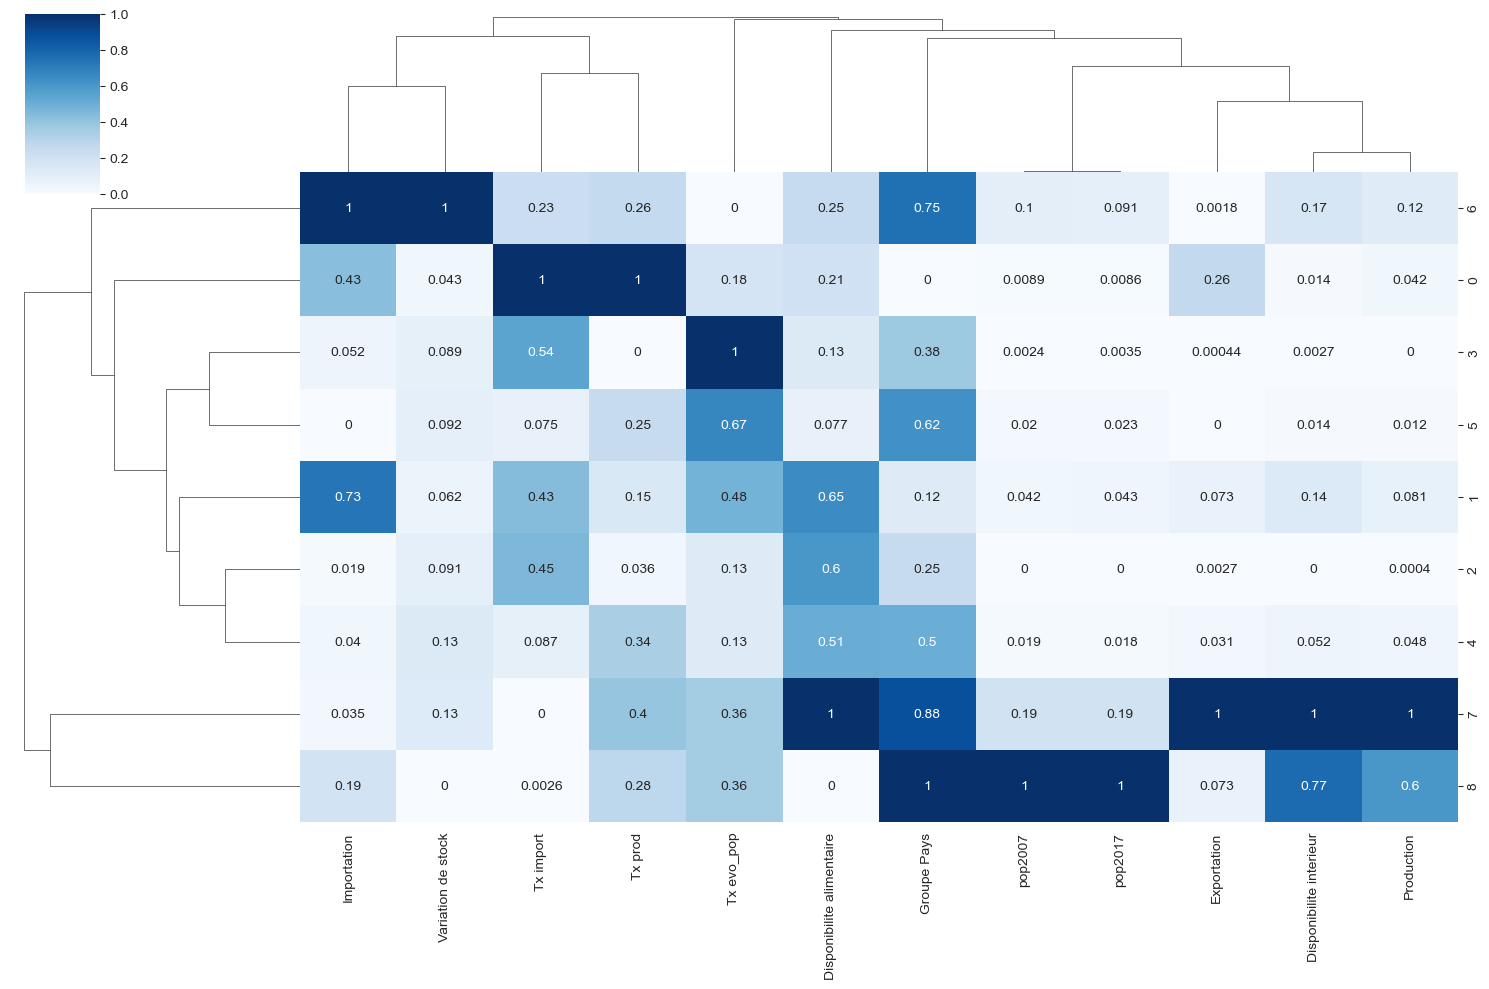

In [19]:
clustermap = sns.clustermap(df_centroids, figsize = (15, 10), annot = True, standard_scale = 1, cmap = "Blues")
plt.show()

row_labels = clustermap.dendrogram_row.reordered_ind
col_labels = clustermap.dendrogram_col.reordered_ind
table_data = df_centroids.iloc[row_labels, col_labels]

##### **Groupe 1**: <small><strong>Ce groupe de pays présente une disponibilité alimentaire relativement faible, avec une dépendance significative à l'importation. Ils affichent une production et une disponibilité intérieure modérées, mais une variation de stock négative. Leur taux de croissance démographique est faible.</strong></small>

##### <u>Groupe 2</u>: <span style="font-size: small;">Les pays de ce groupe ont une disponibilité alimentaire moyenne élevée, avec une production et une disponibilité intérieure importante. Ils exportent une quantité significative de produits alimentaires, mais dépendent également des importations pour répondre à la demande intérieure. Leur taux de croissance démographique est plus élevé que celui du groupe précédent.</span>

##### Groupe 3: <small><strong>Ce groupe de pays affiche une disponibilité alimentaire moyenne élevée malgré une production relativement faible. Ils sont moins dépendants des importations et ont une variation de stock positive. Leur taux de croissance démographique est relativement faible.</strong></small>

##### Groupe 4: <small><strong>Les pays de ce groupe ont une disponibilité alimentaire relativement faible, avec une production et une disponibilité intérieure modestes. Ils dépendent fortement des importations. Leur variation de stock est également négative. Leur taux de croissance démographique élevé.</strong></small>

##### Groupe 5: <small><strong>Ce groupe de pays présente une disponibilité alimentaire moyenne élevée, avec une production et une disponibilité intérieure conséquante. Ils exportent également une quantité significative de produits alimentaires, tandis que leurs importations restent relativement faibles. La variation de stock est positive. Leur taux de croissance démographique est faible.</strong></small>

##### <u>Groupe 6</u>: <span style="font-size: small;">Les pays de ce groupe ont une disponibilité alimentaire relativement faible et dépendent des importations pour répondre à la demande intérieure. Leur production et leur disponibilité intérieure sont modestes, mais ils affichent une variation de stock positive. Il ont une croissance démographique modérée.</span>

##### Groupe 7: <small><strong>Ce groupe de pays présente une disponibilité alimentaire modérée avec une production et une disponibilité intérieure élevées. Ils dépendent fortement des importations et affichent une variation de stock significative. La croissance démographique est stable.</strong></small>

##### Groupe 8: <small><strong>Les pays de ce groupe se distinguent par leur disponibilité alimentaire élevée, leur production et leur disponibilité intérieure considérables. Ils exportent une quantité importante de produits alimentaires et ont une variation de stock positive. Leur taux de croissance démographique est modéré et leurs importations sont faibles, ce qui contribue à une plus grande indépendance alimentaire.</strong></small>

##### Groupe 9: <small><strong>Ce groupe de pays présente une disponibilité alimentaire relativement faible avec une production et une disponibilité intérieure élevées. Ils exportent une quantité modérée de produits alimentaires et dépendent des importations pour répondre à la demande intérieure. Leur variation de stock est négative. La croissance démographique est modérée.</strong></small>

##### Compte tenu des résultats je séléctionne les groupes 2 et 6 car ces pays se distinguent par leur forte demande d'importations alimentaires, leur production alimentaire insuffisante et leur évolution de la population significative.

In [20]:
# Affichage des pays pour chaque groupes
list_pays_g1 = df[df["Groupe Pays"] == 1]
list_pays_g2 = df[df["Groupe Pays"] == 2]
list_pays_g3 = df[df["Groupe Pays"] == 3]
list_pays_g4 = df[df["Groupe Pays"] == 4]
list_pays_g5 = df[df["Groupe Pays"] == 5]
list_pays_g6 = df[df["Groupe Pays"] == 6]
list_pays_g7 = df[df["Groupe Pays"] == 7]
list_pays_g8 = df[df["Groupe Pays"] == 8]
list_pays_g9 = df[df["Groupe Pays"] == 9]

pays_du_groupe = [list_pays_g1, list_pays_g2, list_pays_g3, list_pays_g4, list_pays_g5, list_pays_g6, list_pays_g7, list_pays_g8, list_pays_g9]

for i, pays_du_groupe in enumerate(pays_du_groupe, start=1):
    print("*Groupe*", i)
    for index in pays_du_groupe.index.tolist():
        print(index)
    print()

*Groupe* 1
Belgique
Pays-Bas

*Groupe* 2
Afrique du Sud
Allemagne
Arabie saoudite
Chine - RAS de Hong-Kong
Mexique
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord

*Groupe* 3
Albanie
Antigua-et-Barbuda
Arménie
Bahamas
Bulgarie
Chine - RAS de Macao
Cuba
Danemark
Dominique
Estonie
Grenade
Géorgie
Irlande
Lettonie
Macédoine du Nord
Malte
Monténégro
Nouvelle-Calédonie
Polynésie française
Saint-Kitts-et-Nevis
Saint-Vincent-et-les Grenadines
Sainte-Lucie
Samoa
Suriname
Tchéquie

*Groupe* 4
Angola
Bénin
Cabo Verde
Congo
Djibouti
Gabon
Gambie
Ghana
Guinée
Guinée-Bissau
Haïti
Iraq
Jordanie
Kirghizistan
Koweït
Lesotho
Libéria
Luxembourg
Maldives
Mauritanie
Mongolie
Namibie
Oman
Sao Tomé-et-Principe
Tadjikistan
Timor-Leste
Vanuatu
Émirats arabes unis
Îles Salomon

*Groupe* 5
Argentine
Australie
Barbade
Bolivie (État plurinational de)
Bosnie-Herzégovine
Bélarus
Canada
Chili
Chine, Taiwan Province de
Colombie
Croatie
El Salvador
Espagne
Fidji
Finlande
France
Fédération de Russie
Grèce
Guyana
Ho

### <u>Précision concernant les groupes 7, 8 et 9</u>

##### Groupe 7 : <small><strong>Le Japon à une faible importation alimentaire moyenne, il est également autosuffisant avec sa production et sa disponibilité alimentaire et ce pays à une tendance démographique stable.</strong></small>
##### Groupe 8 : <small><strong>Le Brésil et les États-Unis d'Amérique ont des importation relativement faible, une disponibilité et une production conséquante qui convient suffisament à leurs évolution démographique.</strong></small>
##### Groupe 9 : <small><strong>Bien que ces pays l'Inde et la Chine Continentale soit de gros importateur ils ont une disponibilité et une production importante. Les autres groupe sont des candidats plus "intéressant" car importateur et ils ont moins de disponibilité et de production avec une population qui évolue positivement.</strong></small>

## <span style="color:#000080">Algorithme du K-means</span>

In [21]:
# Methode du coude

In [22]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

sse = []
for k in range(1, 16):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)
    

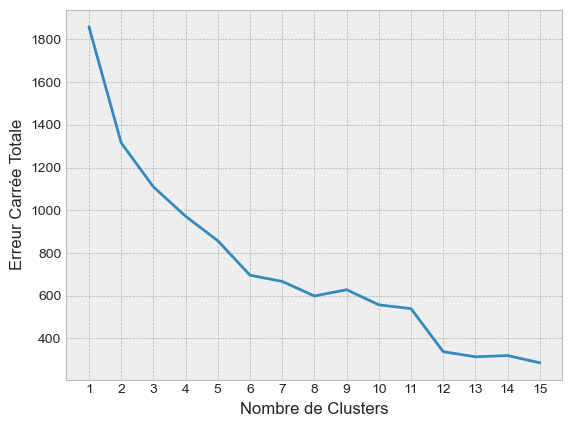

In [23]:
plt.style.use("bmh")
plt.plot(range(1, 16), sse)
plt.xticks(range(1, 16))
plt.xlabel("Nombre de Clusters")
plt.ylabel("Erreur Carrée Totale")
plt.show()

In [24]:
kl = KneeLocator(range(1, 16), sse, curve="convex", direction="decreasing")

print("Le nombre de cluster idéal selon cette méthode est de {}".format(kl.elbow))

Le nombre de cluster idéal selon cette méthode est de 6


In [25]:
# Methode de silhouette

In [26]:
silhouette_coefficients =[]

for k in range(2, 16):
    kmeans = cluster.KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    score = metrics.silhouette_score(df_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

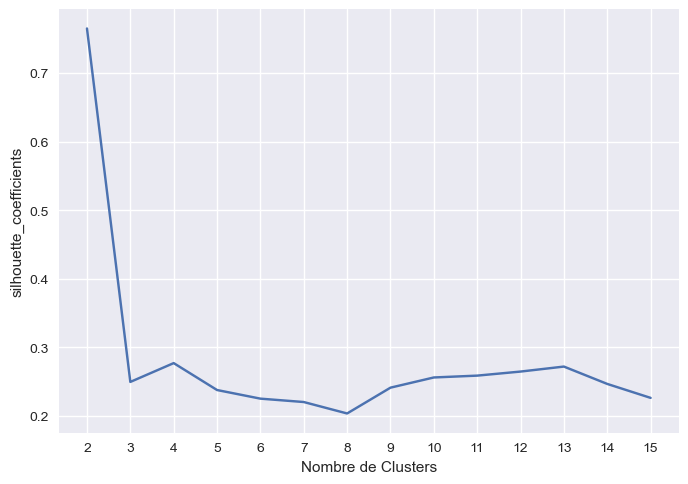

In [27]:
plt.style.use("seaborn")
plt.plot(range(2, 16), silhouette_coefficients)
plt.xticks(range(2, 16))
plt.xlabel("Nombre de Clusters")
plt.ylabel("silhouette_coefficients")
plt.show()

In [28]:
"""Ne trouvant pas le résultat conluant, je continu avec les informations fourni par la méthode du coude"""

'Ne trouvant pas le résultat conluant, je continu avec les informations fourni par la méthode du coude'

In [29]:
nb_clust = cluster.KMeans(init="random", n_clusters=7, n_init=10, max_iter=300, random_state=42)
nb_clust.fit(df_scaled)

KMeans(init='random', n_clusters=7, n_init=10, random_state=42)

In [30]:
df["kmeans"] = nb_clust.labels_
df

Disponibilite alimentaire  Disponibilite interieur  \
Pays                                                                        
Afghanistan                                 1.53                     57.0   
Afrique du Sud                             35.69                   2118.0   
Albanie                                    16.36                     47.0   
Algérie                                     6.38                    277.0   
Allemagne                                  19.47                   1739.0   
...                                          ...                      ...   
Émirats arabes unis                        43.47                    412.0   
Équateur                                   19.31                    341.0   
États-Unis d'Amérique                      55.68                  18266.0   
Éthiopie                                    0.13                     14.0   
Îles Salomon                                4.45                      3.0   

                       Exportation  Importation  Production  \
Pays                                                          
Afghanistan                    0.0         29.0        28.0   
Afrique du Sud                63.0        514.0      1667.0   
Albanie                        0.0         38.0        13.0   
Algérie                        0.0          2.0       275.0   
Allemagne                    646.0        842.0      1514.0   
...                            ...          ...         ...   
Émirats arabes unis           94.0        433.0        48.0   
Équateur                       0.0          0.0       340.0   
États-Unis d'Amérique       3692.0        123.0     21914.0   
Éthiopie                       0.0          1.0        14.0   
Îles Salomon                   0.0          6.0         0.0   

                       Variation de stock    pop2007    pop2017  Tx evo_pop  \
Pays                                                                          
Afghanistan                           0.0   27100536   36296113        0.03   
Afrique du Sud                        0.0   49119759   57009756        0.02   
Albanie                               4.0    3033998    2884169       -0.01   
Algérie                               0.0   34166972   41389189        0.02   
Allemagne                           -29.0   81277830   82658409        0.00   
...                                   ...        ...        ...         ...   
Émirats arabes unis                 -26.0    6168838    9487203        0.04   
Équateur                             -1.0   14296557   16785361        0.02   
États-Unis d'Amérique                80.0  300608429  325084756        0.01   
Éthiopie                              0.0   80674348  106399924        0.03   
Îles Salomon                          3.0     492132     636039        0.03   

                       Tx import  Tx prod  Groupe Pays  kmeans  
Pays                                                            
Afghanistan                 0.51     0.49            6       2  
Afrique du Sud              0.24     0.79            2       4  
Albanie                     0.81     0.28            3       0  
Algérie                     0.01     0.99            6       2  
Allemagne                   0.48     0.87            2       4  
...                          ...      ...          ...     ...  
Émirats arabes unis         1.05     0.12            4       3  
Équateur                    0.00     1.00            6       2  
États-Unis d'Amérique       0.01     1.20            8       5  
Éthiopie                    0.07     1.00            6       2  
Îles Salomon                2.00     0.00            4       3  

[169 rows x 13 columns]

In [31]:
df2 = df
df3 = df

In [32]:
kmeans_centroids = df.drop(["Groupe Pays"], axis=1).groupby("kmeans").mean()
kmeans_centroids

Disponibilite alimentaire  Disponibilite interieur  Exportation  \
kmeans                                                                    
0                       36.268636                45.409091     3.954545   
1                       18.500000              2415.000000    10.000000   
2                        6.905000               233.704545     0.818182   
3                       15.707097               138.741935    25.806452   
4                       25.922687               727.671642   125.626866   
5                       38.680000             15469.666667  2830.333333   
6                        2.220000              3661.000000     4.000000   

        Importation    Production  Variation de stock       pop2007  \
kmeans                                                                
0         36.909091     14.818182            2.272727  1.773889e+06   
1       1069.000000   2215.000000          859.000000  1.284941e+08   
2         18.931818    214.931818           -0.659091  3.327155e+07   
3        127.258065     34.000000           -3.419355  5.839087e+06   
4        119.119403    758.462687           24.253731  2.485901e+07   
5        192.666667  18117.000000           10.000000  6.122443e+08   
6          0.000000   3545.000000         -119.000000  1.183209e+09   

             pop2017  Tx evo_pop  Tx import   Tx prod  
kmeans                                                 
0       1.745584e+06    0.003182   0.862727  0.257273  
1       1.275027e+08    0.000000   0.440000  0.920000  
2       4.101779e+07    0.023864   0.138182  0.884773  
3       7.670242e+06    0.026452   1.132903  0.185484  
4       2.668616e+07    0.005522   0.255672  1.107910  
5       6.513135e+08    0.010000   0.010000  1.206667  
6       1.338677e+09    0.010000   0.000000  0.970000

In [33]:
kmeans_pays_g0 = df[df["kmeans"] == 0]
kmeans_pays_g1 = df[df["kmeans"] == 1]
kmeans_pays_g2 = df[df["kmeans"] == 2]
kmeans_pays_g3 = df[df["kmeans"] == 3]
kmeans_pays_g4 = df[df["kmeans"] == 4]
kmeans_pays_g5 = df[df["kmeans"] == 5]
kmeans_pays_g6 = df[df["kmeans"] == 6]

for i in range(0, 7):
    print("*Groupe*", i)
    list_pays = df[df["kmeans"] == i]
    for index in list_pays.index.tolist():
        print(index)
    print()

*Groupe* 0
Albanie
Antigua-et-Barbuda
Arménie
Bahamas
Bulgarie
Cuba
Dominique
Estonie
Grenade
Géorgie
Lettonie
Macédoine du Nord
Malte
Monténégro
Nouvelle-Calédonie
Polynésie française
Saint-Kitts-et-Nevis
Saint-Vincent-et-les Grenadines
Sainte-Lucie
Samoa
Suriname
Trinité-et-Tobago

*Groupe* 1
Japon

*Groupe* 2
Afghanistan
Algérie
Azerbaïdjan
Bangladesh
Belize
Botswana
Burkina Faso
Cambodge
Cameroun
Côte d'Ivoire
Eswatini
Guatemala
Honduras
Indonésie
Jordanie
Kenya
Kiribati
Liban
Madagascar
Malawi
Mali
Mozambique
Niger
Nigéria
Ouganda
Pakistan
Paraguay
Philippines
Rwanda
République centrafricaine
République populaire démocratique de Corée
République-Unie de Tanzanie
Sierra Leone
Sri Lanka
Sénégal
Tchad
Togo
Turkménistan
Yémen
Zambie
Zimbabwe
Égypte
Équateur
Éthiopie

*Groupe* 3
Angola
Arabie saoudite
Bénin
Cabo Verde
Chine - RAS de Hong-Kong
Chine - RAS de Macao
Congo
Djibouti
Gabon
Gambie
Ghana
Guinée
Guinée-Bissau
Haïti
Iraq
Kirghizistan
Koweït
Lesotho
Libéria
Luxembourg
Maldives
Ma

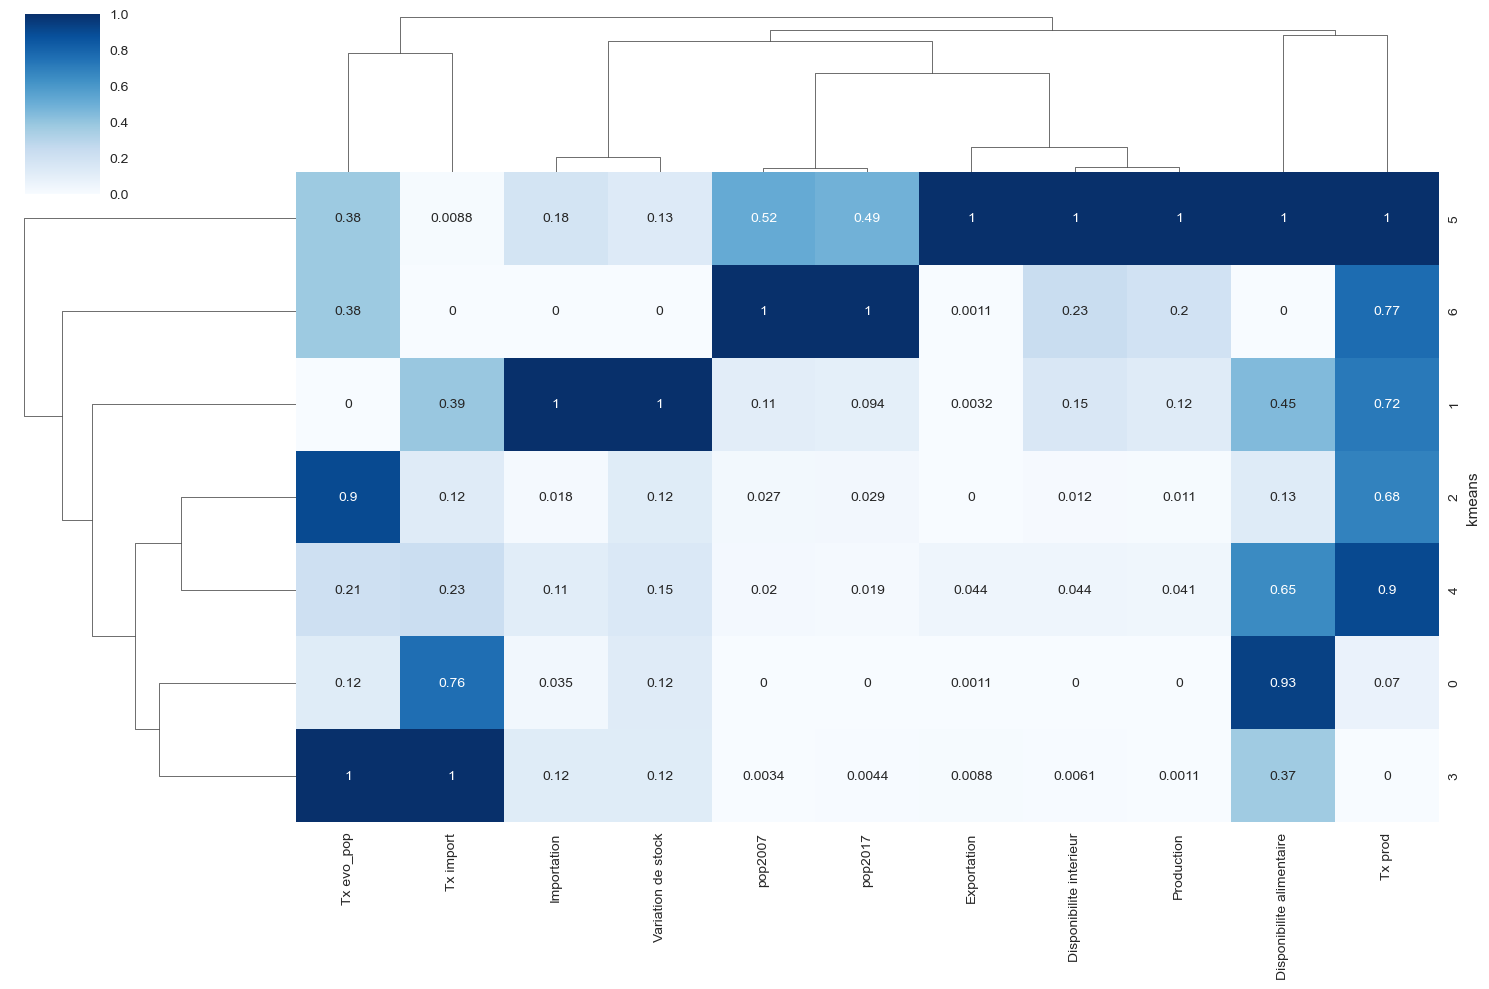

In [34]:
clustermap2 = sns.clustermap(kmeans_centroids, figsize=(15, 10), annot=True, standard_scale=1, cmap="Blues")
plt.show()

row_labels2 = clustermap2.dendrogram_row.reordered_ind
col_labels2 = clustermap2.dendrogram_col.reordered_ind

# Vérification des index des lignes
valid_row_labels = all(0 <= idx < len(kmeans_centroids.index) for idx in row_labels2)
# Vérification des index des colonnes
valid_col_labels = all(0 <= idx < len(kmeans_centroids.columns) for idx in col_labels2)

if valid_row_labels and valid_col_labels:
    table_data2 = kmeans_centroids.iloc[row_labels2, col_labels2]
    table_data2
else:
    if not valid_row_labels:
        print("Les index des lignes sont hors limites.")
    if not valid_col_labels:
        print("Les index des colonnes sont hors limites.")

##### **Groupe 0**: <small><strong> Ce groupe présente une disponibilité intérieure élevée, des niveaux d'exportation et d'importation modérés, ainsi qu'une production alimentaire élevée.</strong></small>

##### Groupe 1: <small><strong>Les pays de ce groupe se caractérise par une disponibilité alimentaire modérée, une disponibilité intérieure faible et des niveaux d'importation relativement élevés par rapport aux autres groupes.</strong></small>

##### Groupe 2: <small><strong>Ce groupe, la disponibilité alimentaire est faible et la disponibilité intérieure est élevée. Les niveaux d'exportation et d'importation sont très faibles, tandis que la production alimentaire est élevée.</strong></small>

##### <u>Groupe 3</u>: <span style="font-size: small;">Les pays de ce groupe présente une disponibilité alimentaire élevée, une disponibilité intérieure élevée et des niveaux d'exportation et d'importation élevés. La production alimentaire est également élevée.</span>

##### Groupe 4: <small><strong>Ce groupe présente une disponibilité alimentaire très élevée, une disponibilité intérieure très élevée, une production alimentaire élevée, mais des niveaux d'importation relativement faibles.</strong></small>

##### <u>Groupe 5</u>: <span style="font-size: small;">Les pays de ce groupe se caractérise par une disponibilité alimentaire très élevée, une disponibilité intérieure élevée, des niveaux élevés d'exportation, d'importation et de production alimentaire.</span>

##### Groupe 6: <small><strong>Ce groupe la disponibilité alimentaire est très élevée, mais la disponibilité intérieure est faible. Les niveaux d'exportation et d'importation sont très faibles, tout comme la production alimentaire.</strong></small>

In [35]:
print(list_pays_g2)
print(list_pays_g6)
print(kmeans_pays_g3)
print(kmeans_pays_g5)

                                                    Disponibilite alimentaire  \
Pays                                                                            
Afrique du Sud                                                          35.69   
Allemagne                                                               19.47   
Arabie saoudite                                                         43.36   
Chine - RAS de Hong-Kong                                                53.51   
Mexique                                                                 32.52   
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                      31.94   

                                                    Disponibilite interieur  \
Pays                                                                          
Afrique du Sud                                                       2118.0   
Allemagne                                                            1739.0   
Arabie saoudite                    

In [36]:
pays_cah_kmeans = []

pays_cah_kmeans.extend(list_pays_g2)
pays_cah_kmeans.extend(list_pays_g6)
pays_cah_kmeans.extend(kmeans_pays_g3)
pays_cah_kmeans.extend(kmeans_pays_g5)

pays_cah_kmeans

['Disponibilite alimentaire',
 'Disponibilite interieur',
 'Exportation',
 'Importation',
 'Production',
 'Variation de stock',
 'pop2007',
 'pop2017',
 'Tx evo_pop',
 'Tx import',
 'Tx prod',
 'Groupe Pays',
 'Disponibilite alimentaire',
 'Disponibilite interieur',
 'Exportation',
 'Importation',
 'Production',
 'Variation de stock',
 'pop2007',
 'pop2017',
 'Tx evo_pop',
 'Tx import',
 'Tx prod',
 'Groupe Pays',
 'Disponibilite alimentaire',
 'Disponibilite interieur',
 'Exportation',
 'Importation',
 'Production',
 'Variation de stock',
 'pop2007',
 'pop2017',
 'Tx evo_pop',
 'Tx import',
 'Tx prod',
 'Groupe Pays',
 'kmeans',
 'Disponibilite alimentaire',
 'Disponibilite interieur',
 'Exportation',
 'Importation',
 'Production',
 'Variation de stock',
 'pop2007',
 'pop2017',
 'Tx evo_pop',
 'Tx import',
 'Tx prod',
 'Groupe Pays',
 'kmeans']

In [37]:
cah_km = pd.DataFrame(pays_cah_kmeans)

In [38]:
cah_km.to_excel("cah_km.xls", index=False)

In [39]:
CAHG2 = pd.DataFrame(list_pays_g2).reset_index()
CAHG2.rename(columns={"index": "Pays"}, inplace=True)
CAHG2

Pays  \
0                                     Afrique du Sud   
1                                          Allemagne   
2                                    Arabie saoudite   
3                           Chine - RAS de Hong-Kong   
4                                            Mexique   
5  Royaume-Uni de Grande-Bretagne et d'Irlande du...   

   Disponibilite alimentaire  Disponibilite interieur  Exportation  \
0                      35.69                   2118.0         63.0   
1                      19.47                   1739.0        646.0   
2                      43.36                   1435.0         10.0   
3                      53.51                    280.0        663.0   
4                      32.52                   4219.0          9.0   
5                      31.94                   2234.0        359.0   

   Importation  Production  Variation de stock    pop2007    pop2017  \
0        514.0      1667.0                 0.0   49119759   57009756   
1        842.0      1514.0               -29.0   81277830   82658409   
2        722.0       616.0              -108.0   25184597   33101178   
3        907.0        24.0               -12.0    6840015    7306322   
4        972.0      3249.0                -6.0  109170502  124777324   
5        779.0      1814.0                 0.0   61455162   66727460   

   Tx evo_pop  Tx import  Tx prod  Groupe Pays  
0        0.02       0.24     0.79            2  
1        0.00       0.48     0.87            2  
2        0.03       0.50     0.43            2  
3        0.01       3.24     0.09            2  
4        0.01       0.23     0.77            2  
5        0.01       0.35     0.81            2

In [40]:
CAHG6 = pd.DataFrame(list_pays_g6).reset_index()
CAHG6.rename(columns={"index" : "Pays"},inplace=True)
CAHG6

Pays  Disponibilite alimentaire  Disponibilite interieur  \
0   Afghanistan                       1.53                     57.0   
1       Algérie                       6.38                    277.0   
2      Autriche                      18.20                    173.0   
3   Azerbaïdjan                      13.11                    129.0   
4    Bangladesh                       1.50                    250.0   
..          ...                        ...                      ...   
58       Zambie                       3.42                     60.0   
59     Zimbabwe                       4.68                     76.0   
60       Égypte                      12.96                   1250.0   
61     Équateur                      19.31                    341.0   
62     Éthiopie                       0.13                     14.0   

    Exportation  Importation  Production  Variation de stock    pop2007  \
0           0.0         29.0        28.0                 0.0   27100536   
1           0.0          2.0       275.0                 0.0   34166972   
2          78.0        110.0       148.0                 8.0    8313736   
3           0.0         27.0       104.0                 2.0    8724243   
4           0.0          0.0       249.0                 0.0  142660376   
..          ...          ...         ...                 ...        ...   
58          1.0         12.0        49.0                 0.0   12502958   
59          0.0          6.0        69.0                 0.0   12255922   
60          1.0        110.0      1118.0               -23.0   78232126   
61          0.0          0.0       340.0                -1.0   14296557   
62          0.0          1.0        14.0                 0.0   80674348   

      pop2017  Tx evo_pop  Tx import  Tx prod  Groupe Pays  
0    36296113        0.03       0.51     0.49            6  
1    41389189        0.02       0.01     0.99            6  
2     8819901        0.01       0.64     0.86            6  
3     9845320        0.01       0.21     0.81            6  
4   159685424        0.01       0.00     1.00            6  
..        ...         ...        ...      ...          ...  
58   16853599        0.03       0.20     0.82            6  
59   14236595        0.02       0.08     0.91            6  
60   96442591        0.02       0.09     0.89            6  
61   16785361        0.02       0.00     1.00            6  
62  106399924        0.03       0.07     1.00            6  

[63 rows x 13 columns]

In [41]:
KMEANS3 = pd.DataFrame(kmeans_pays_g3).reset_index()
KMEANS3.rename(columns={"index" : "Pays"},inplace=True)
KMEANS3

Pays  Disponibilite alimentaire  \
0                     Angola                      10.56   
1            Arabie saoudite                      43.36   
2                      Bénin                      14.40   
3                 Cabo Verde                      17.62   
4   Chine - RAS de Hong-Kong                      53.51   
5       Chine - RAS de Macao                      34.47   
6                      Congo                      21.53   
7                   Djibouti                       2.68   
8                      Gabon                      29.33   
9                     Gambie                       3.53   
10                     Ghana                       7.24   
11                    Guinée                       4.08   
12             Guinée-Bissau                       2.16   
13                     Haïti                       8.91   
14                      Iraq                      14.95   
15              Kirghizistan                       3.10   
16                    Koweït                      46.25   
17                   Lesotho                       7.93   
18                   Libéria                      10.67   
19                Luxembourg                      18.33   
20                  Maldives                      13.50   
21                Mauritanie                       5.14   
22                  Mongolie                       2.77   
23                   Namibie                      11.53   
24                      Oman                      21.63   
25      Sao Tomé-et-Principe                       9.47   
26               Tadjikistan                       4.45   
27               Timor-Leste                       4.24   
28                   Vanuatu                      11.66   
29       Émirats arabes unis                      43.47   
30              Îles Salomon                       4.45   

    Disponibilite interieur  Exportation  Importation  Production  \
0                     319.0          0.0        277.0        42.0   
1                    1435.0         10.0        722.0       616.0   
2                     161.0          0.0        123.0        18.0   
3                      10.0          0.0         12.0         1.0   
4                     280.0        663.0        907.0        24.0   
5                      19.0          0.0         23.0         3.0   
6                     110.0          0.0        104.0         7.0   
7                       3.0          0.0          3.0         0.0   
8                      78.0          0.0         76.0         4.0   
9                       8.0          0.0         16.0         2.0   
10                    211.0          0.0        151.0        60.0   
11                     50.0          0.0         37.0        13.0   
12                      4.0          0.0          4.0         3.0   
13                     98.0          0.0         89.0         9.0   
14                    566.0          0.0        470.0        96.0   
15                     32.0          0.0         25.0         7.0   
16                    189.0          4.0        137.0        56.0   
17                     17.0          0.0         15.0         2.0   
18                     50.0          0.0         48.0        15.0   
19                     11.0          1.0         11.0         0.0   
20                     12.0          0.0         12.0         0.0   
21                     22.0          0.0         24.0         5.0   
22                      9.0          0.0         10.0         0.0   
23                     28.0         12.0         29.0        11.0   
24                    114.0         16.0        126.0         7.0   
25                      2.0          0.0          2.0         1.0   
26                     40.0          0.0         38.0         2.0   
27                      5.0          0.0         11.0         1.0   
28                      3.0          0.0          4.0         1.0   
29                    412.0         94.0        433.0        48.0

In [42]:
KMEANS5 = pd.DataFrame(kmeans_pays_g5).reset_index()
KMEANS5.rename(columns={"index" : "Pays"},inplace=True)
KMEANS5

Pays  Disponibilite alimentaire  Disponibilite interieur  \
0                 Brésil                      48.03                   9982.0   
1    Chine, continentale                      12.33                  18161.0   
2  États-Unis d'Amérique                      55.68                  18266.0   

   Exportation  Importation  Production  Variation de stock     pop2007  \
0       4223.0          3.0     14201.0                 0.0   190130443   
1        576.0        452.0     18236.0               -50.0  1345993888   
2       3692.0        123.0     21914.0                80.0   300608429   

      pop2017  Tx evo_pop  Tx import  Tx prod  Groupe Pays  kmeans  
0   207833823        0.01       0.00     1.42            8       5  
1  1421021791        0.01       0.02     1.00            9       5  
2   325084756        0.01       0.01     1.20            8       5

In [43]:
#data1 = CAHG6["Pays"].tolist()
#data2 = CAHG6["Pays"].tolist()
#data3 = KMEANS3["Pays"].tolist()
#data4 = KMEANS5["Pays"].tolist()

#tous_les_pays = data1 + data2 + data3 + data4

#compteur_pays = Counter(tous_les_pays)

#pays_multiples = [pays for pays, count in compteur_pays.items() if count > 2]
#print(pays_multiples)

In [44]:
data1 = pd.DataFrame({"Pays": CAHG2["Pays"].tolist()})
data2 = pd.DataFrame({"Pays": CAHG6["Pays"].tolist()})
data3 = pd.DataFrame({"Pays": KMEANS3["Pays"].tolist()})
data4 = pd.DataFrame({"Pays": KMEANS5["Pays"].tolist()})

data_frames = {"CAHG2": data1, "CAHG6": data2, "KMEANS3": data3, "KMEANS5": data4}
common_values = {}
count = 0

for df_name, df in data_frames.items():
    unique_values = df["Pays"].unique()
    for value in unique_values:
        if value not in common_values:
            common_values[value] = [df_name]
        else:
            common_values[value].append(df_name)
            count += 1

print("Pays présents dans plusieurs DataFrames :", count)
for value, data_frames in common_values.items():
    if len(data_frames) > 1:  # Filtrer les pays présents dans plusieurs DataFrames
        print(f"{value}, {data_frames}")

Pays présents dans plusieurs DataFrames : 2
Arabie saoudite, ['CAHG2', 'KMEANS3']
Chine - RAS de Hong-Kong, ['CAHG2', 'KMEANS3']


## <span style="color:#000080">Observation des centroides</span>

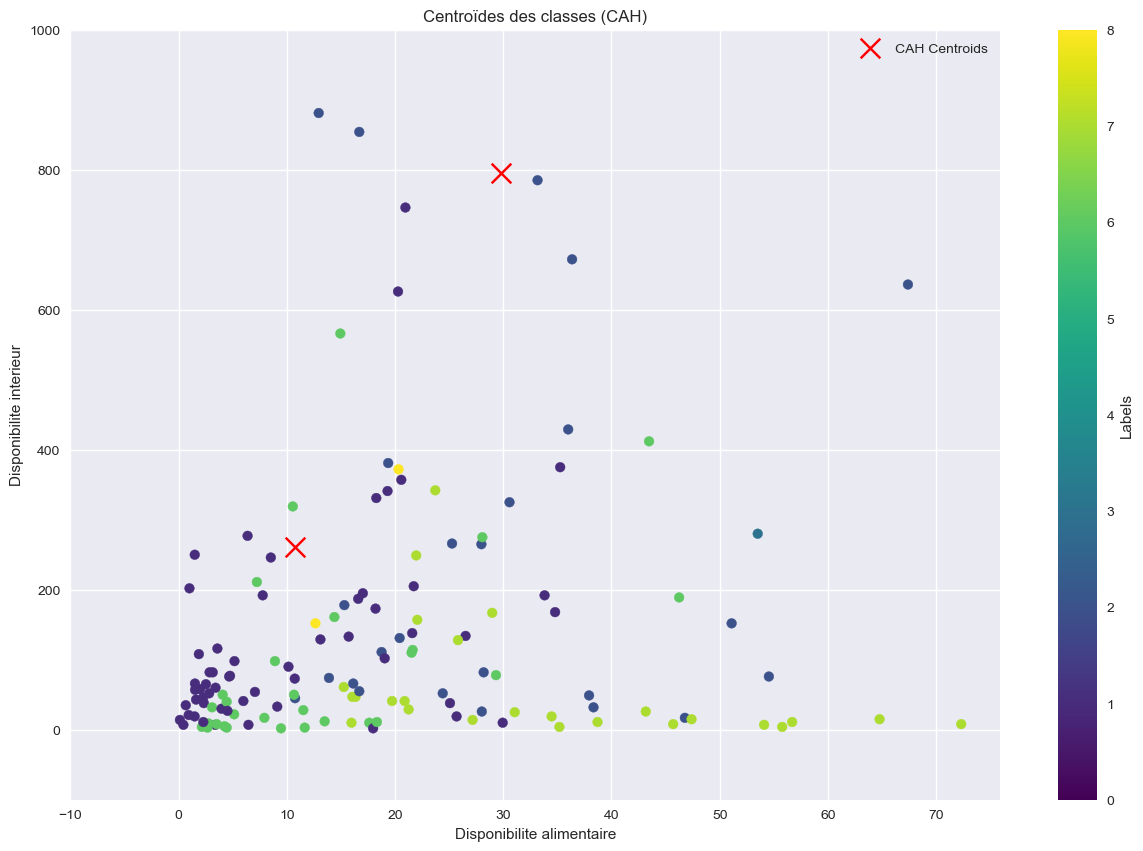

In [45]:
# Effectuer une classification hiérarchique agglomérative sur df_scaled
cah = AgglomerativeClustering(n_clusters=9)
cah_labels = cah.fit_predict(df_scaled2)

# Obtenir les centroïdes des classes
cah_centroids = []

for i in range(3):
    cah_centroids.append(np.mean(df2.iloc[cah_labels == i], axis=0))

# Extraire les coordonnées x et y des centroïdes
cah_centroids_x = [centroid[0] for centroid in cah_centroids]
cah_centroids_y = [centroid[1] for centroid in cah_centroids]

# Créer un tableau de couleurs discrètes pour chaque point
num_points = len(df2)
colors = plt.cm.Set1(np.linspace(0, 1, num_points))

# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(15, 10))

# Afficher les données avec des couleurs distinctes
scatter = ax.scatter(df2['Disponibilite alimentaire'], df2['Disponibilite interieur'], c=cah_labels, cmap='viridis')

# Afficher les centroids de CAH avec des croix rouges
cah_centroid_scatter = ax.scatter(cah_centroids_x, cah_centroids_y, marker='x', color='red', s=200, label='CAH Centroids')

# Ajouter la légende
ax.legend()

# Ajouter les labels des axes
ax.set_title('Centroïdes des classes (CAH)')
ax.set_xlabel('Disponibilite alimentaire')
ax.set_ylabel('Disponibilite interieur')

# Ajuster les limites des axes x et y
ax.set_xlim(-10, ax.get_xlim()[1])  # Ajuste la limite inférieure de l'axe x à -70
ax.set_ylim(-100, 1000)  # Ajuste la limite supérieure de l'axe y à 5000

# Ajouter une barre de couleur pour les labels
cbar = plt.colorbar(scatter)
cbar.set_label('Labels')

# Afficher le graphique
plt.show()

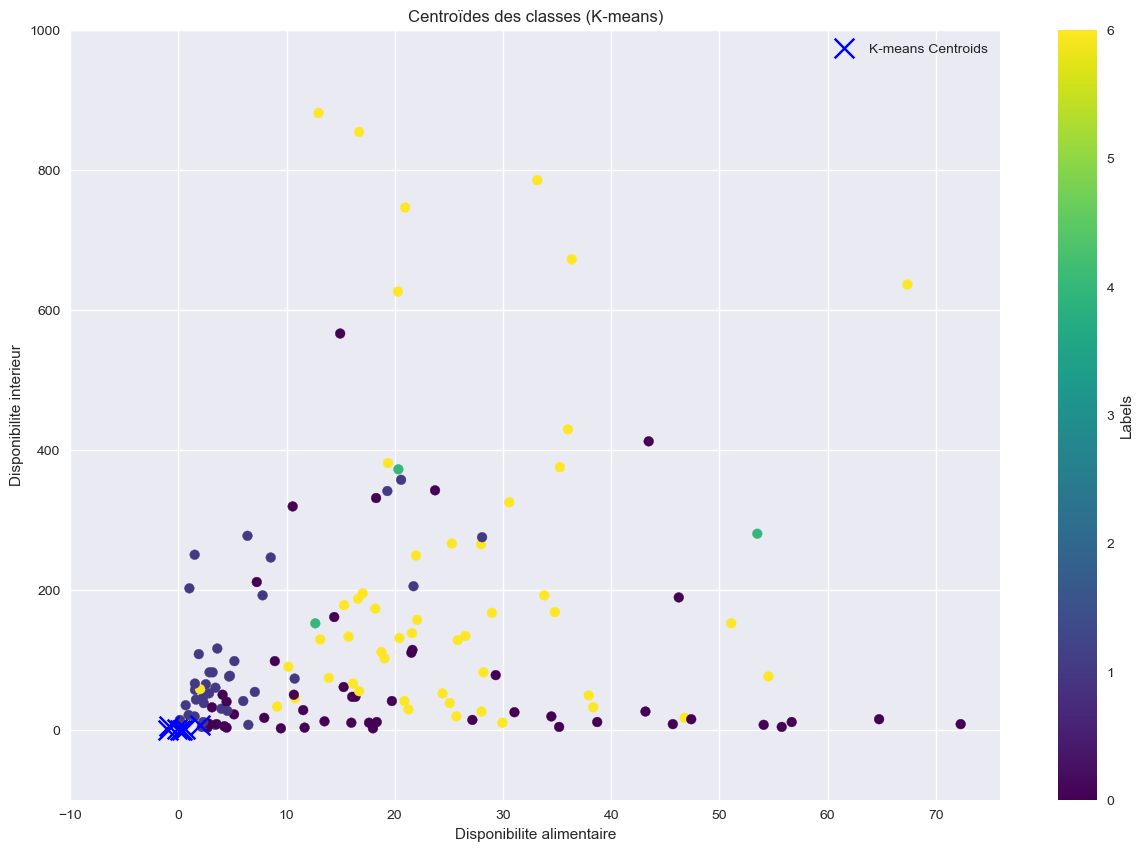

In [46]:
# Effectuer une classification K-means sur df_scaled
kmeans = KMeans(n_clusters=7)
kmeans_labels = kmeans.fit_predict(df_scaled)

# Obtenir les centroïdes des classes
kmeans_centroids = kmeans.cluster_centers_

# Extraire les coordonnées x et y des centroïdes
kmeans_centroids_x = [centroid[0] for centroid in kmeans_centroids]
kmeans_centroids_y = [centroid[1] for centroid in kmeans_centroids]

# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(15, 10))

# Afficher les données avec des couleurs distinctes
scatter = ax.scatter(df2['Disponibilite alimentaire'], df2['Disponibilite interieur'], c=kmeans_labels, cmap='viridis')

# Afficher les centroids de K-means avec des croix bleues
kmeans_centroid_scatter = ax.scatter(kmeans_centroids_x, kmeans_centroids_y, marker='x', color='blue', s=200, label='K-means Centroids')

# Ajouter la légende
ax.legend()

# Ajouter les labels des axes
ax.set_title('Centroïdes des classes (K-means)')
ax.set_xlabel('Disponibilite alimentaire')
ax.set_ylabel('Disponibilite interieur')

# Ajuster les limites des axes x et y
ax.set_xlim(-10, ax.get_xlim()[1])
ax.set_ylim(-100, 1000)

# Ajouter une barre de couleur pour les labels
cbar = plt.colorbar(scatter)
cbar.set_label('Labels')

# Afficher le graphique
plt.show()

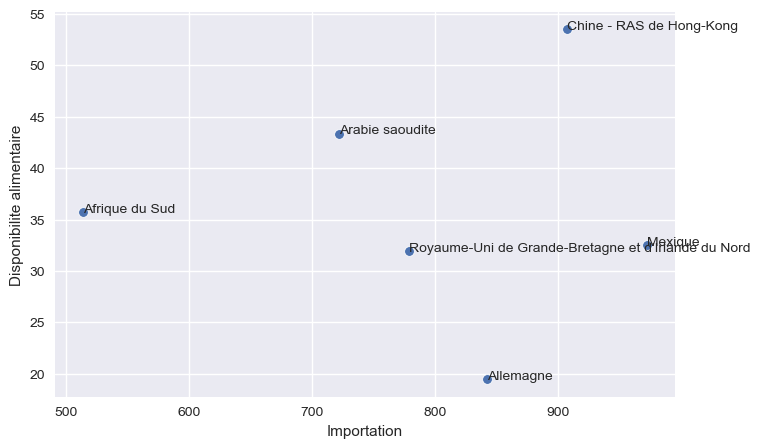

In [47]:
# CAHG2
plt.figure(figsize=(8,5))

sns.scatterplot(data=CAHG2, x=CAHG2["Importation"], y=CAHG2["Disponibilite alimentaire"])

a = pd.concat({'x': CAHG2["Importation"], 'y': CAHG2["Disponibilite alimentaire"], 'val': CAHG2["Pays"]}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.1, point['y'], str(point['val']))

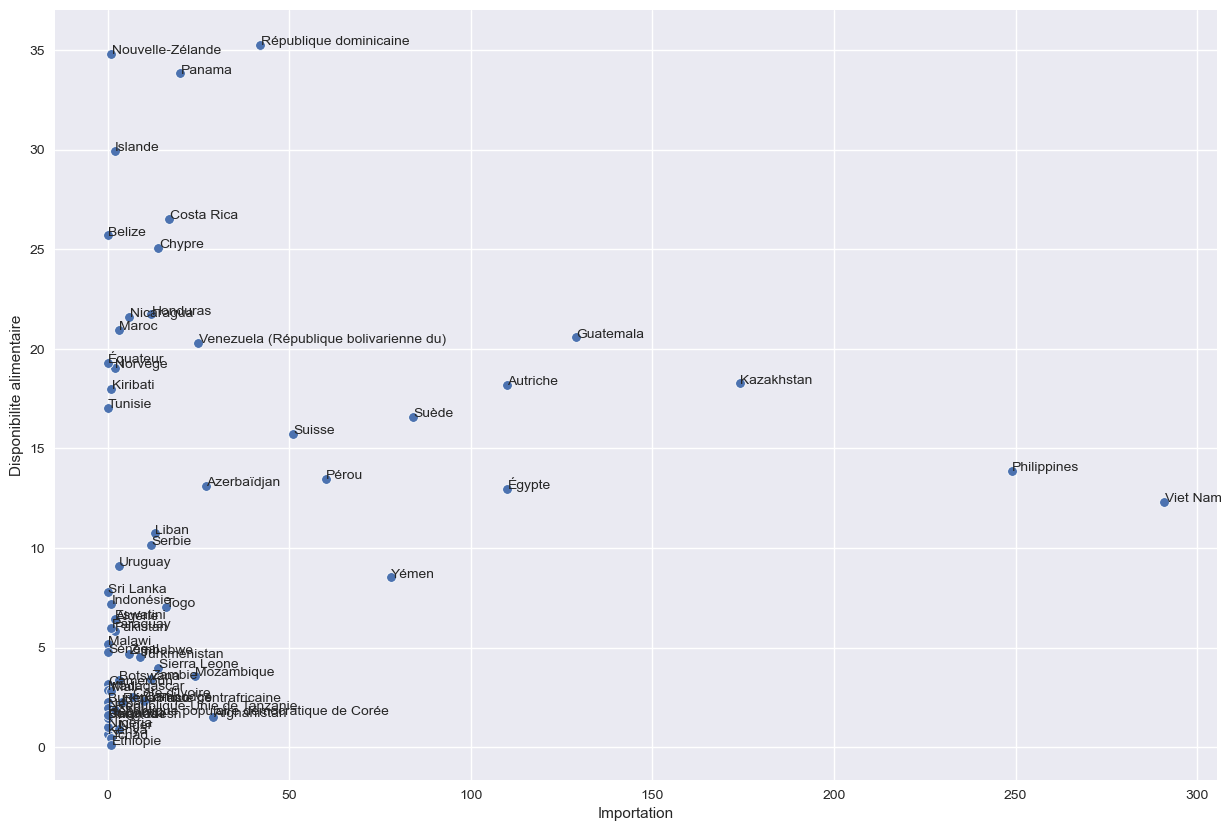

In [48]:
# CAHG6
plt.figure(figsize=(15,10))

sns.scatterplot(data=CAHG6, x=CAHG6["Importation"], y=CAHG6["Disponibilite alimentaire"])

a = pd.concat({'x': CAHG6["Importation"], 'y': CAHG6["Disponibilite alimentaire"], 'val': CAHG6["Pays"]}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.1, point['y'], str(point['val']))

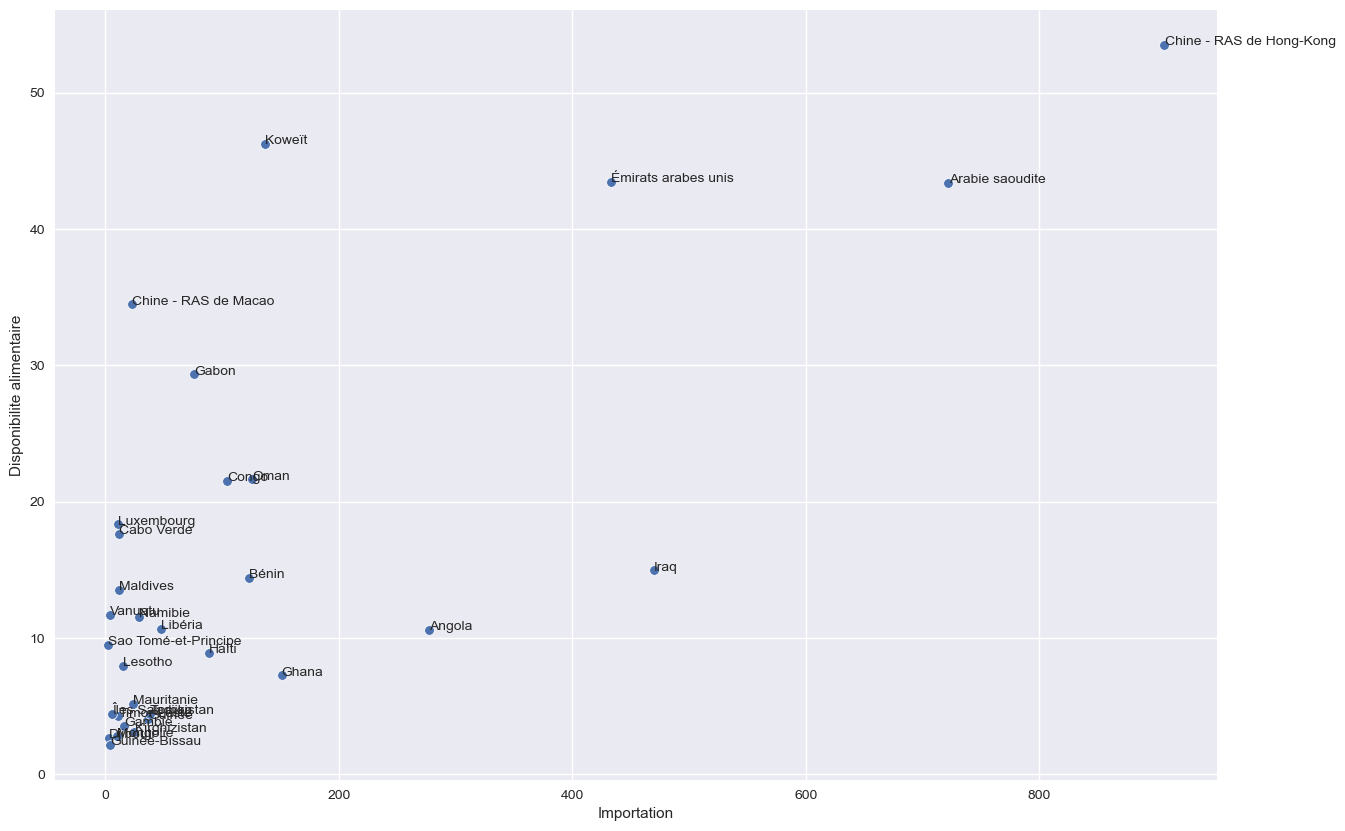

In [49]:
# KMEANS3
plt.figure(figsize=(15,10))

sns.scatterplot(data=KMEANS3, x=KMEANS3["Importation"], y=KMEANS3["Disponibilite alimentaire"])

a = pd.concat({'x': KMEANS3["Importation"], 'y': KMEANS3["Disponibilite alimentaire"], 'val': KMEANS3["Pays"]}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.1, point['y'], str(point['val']))

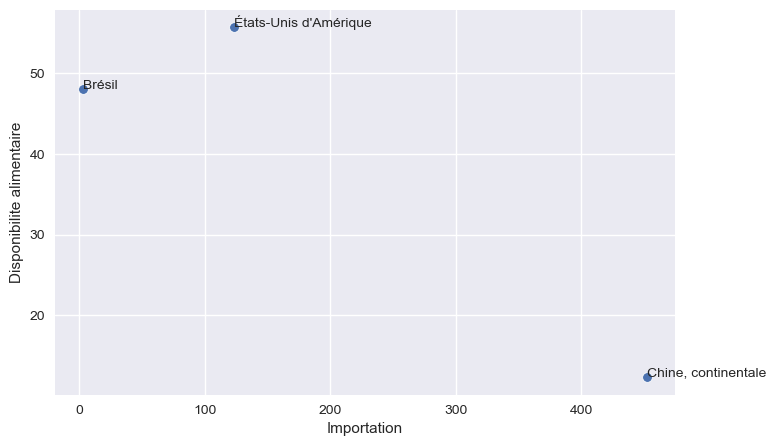

In [50]:
# KMEANS5
plt.figure(figsize=(8,5))

sns.scatterplot(data=KMEANS5, x=KMEANS5["Importation"], y=KMEANS5["Disponibilite alimentaire"])

a = pd.concat({'x': KMEANS5["Importation"], 'y': KMEANS5["Disponibilite alimentaire"], 'val': KMEANS5["Pays"]}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.1, point['y'], str(point['val']))

In [51]:
# Effectuer une classification hiérarchique agglomérative sur df_scaled
cah = AgglomerativeClustering(n_clusters=9)
cah_labels = cah.fit_predict(df_scaled2)

# Effectuer une classification K-means sur df_scaled
kmeans = KMeans(n_clusters=7)
kmeans_labels = kmeans.fit_predict(df_scaled)

# Obtenir les centroïdes des classes
cah_centroids = []
kmeans_centroids = []

for i in range(3):
    cah_centroids.append(np.mean(df2.iloc[cah_labels == i], axis=0))
    kmeans_centroids.append(kmeans.cluster_centers_[i])

# Extraire les coordonnées x et y des centroïdes
cah_centroids_x = [centroid[0] for centroid in cah_centroids]
cah_centroids_y = [centroid[1] for centroid in cah_centroids]
kmeans_centroids_x = [centroid[0] for centroid in kmeans_centroids]
kmeans_centroids_y = [centroid[1] for centroid in kmeans_centroids]

# Créer un DataFrame à partir des coordonnées des centroïdes
data = pd.DataFrame({
    'Disponibilite alimentaire': cah_centroids_x + kmeans_centroids_x,
    'Disponibilite interieur': cah_centroids_y + kmeans_centroids_y,
    'Cluster': ['CAH Centroids'] * len(cah_centroids_x) + ['K-means Centroids'] * len(kmeans_centroids_x)
})

# Tracer le graphique en 3D
fig = px.scatter_3d(data, x='Disponibilite alimentaire', y='Disponibilite interieur', z='Cluster',
                    color='Cluster', symbol='Cluster', width=800, height=600)

fig.update_layout(
    scene=dict(
        xaxis_title='Disponibilite alimentaire',
        yaxis_title='Disponibilite interieur',
        zaxis_title='Cluster',
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()

## <span style="color:#000080">Analyse en Composantes Principales (PCA)</span>

In [52]:
pca = decomposition.PCA(svd_solver="full")

coord = pca.fit_transform(df_scaled)
print(pca.n_components_)

11


## Ebouli des valeurs propres

In [53]:
n_comp = 11
data_pca = df2

data_pca = data_pca.fillna(0)
X=data_pca.values
names = df2.index
features = data_pca.columns

# Centrage - Réduction
std_scale = preprocessing.StandardScaler().fit(X)
df_scaled = std_scale.transform(X)

# Calcul composantes principales
pca = decomposition.PCA(n_components = n_comp)
pca.fit(df_scaled2)

# Proportion de la variance expliquée
pca.explained_variance_ratio_.cumsum()

array([0.35196739, 0.50650407, 0.64557203, 0.74952995, 0.8363392 ,
       0.90115797, 0.95637736, 0.98845278, 0.99995379, 1.        ,
       1.        ])

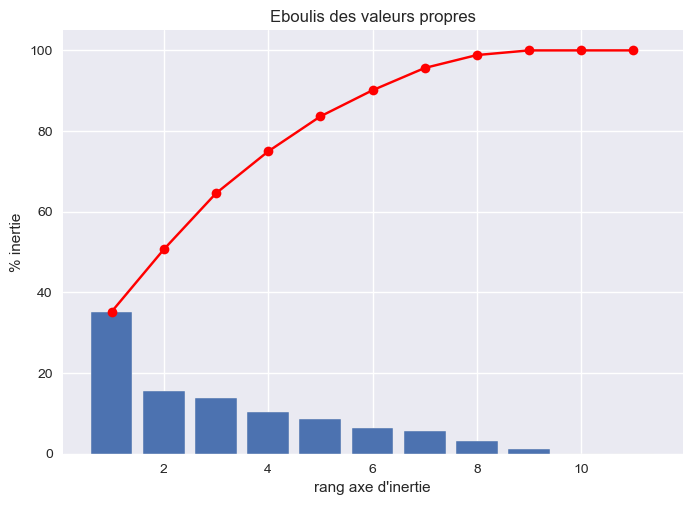

In [54]:
display_scree_eigenvalues(pca)

In [55]:
# Calcul des valeurs propres
eigenvalues = pca.explained_variance_

# Calcul du pourcentage de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Création du tableau numpy
scree_plot_data = np.column_stack((eigenvalues, explained_variance_ratio, cumulative_variance_ratio))

# Affichage du tableau
print(scree_plot_data)

[[3.89468676e+00 3.51967389e-01 3.51967389e-01]
 [1.71002202e+00 1.54536686e-01 5.06504074e-01]
 [1.53885313e+00 1.39067953e-01 6.45572028e-01]
 [1.15034390e+00 1.03957921e-01 7.49529949e-01]
 [9.60585738e-01 8.68092545e-02 8.36339203e-01]
 [7.17250532e-01 6.48187679e-02 9.01157971e-01]
 [6.11028854e-01 5.52193908e-02 9.56377362e-01]
 [3.54929761e-01 3.20754168e-02 9.88452779e-01]
 [1.27264163e-01 1.15010110e-02 9.99953790e-01]
 [5.11305711e-04 4.62072940e-05 9.99999997e-01]
 [3.16451330e-08 2.85980761e-09 1.00000000e+00]]


In [56]:
n_comp = 5
cah_groups = df2["Groupe Pays"]
kmeans_groups = df2["kmeans"]

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(df_scaled)

PCA(n_components=5)

In [57]:
print('Variance expliquée pour chaque composantes :', pca.explained_variance_ratio_)
print('Variance expliquée cumulée pour les composantes :', pca.explained_variance_ratio_.cumsum())

Variance expliquée pour chaque composantes : [0.32972788 0.16336527 0.13027928 0.08803084 0.07621399]
Variance expliquée cumulée pour les composantes : [0.32972788 0.49309314 0.62337242 0.71140326 0.78761725]


## Les Correlations

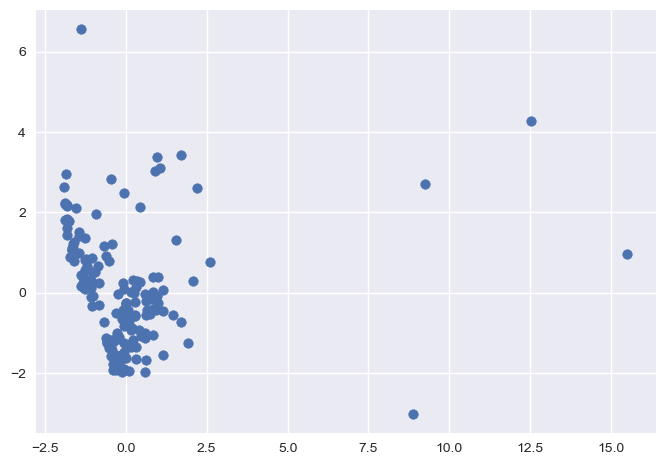

In [58]:
# projeter X sur les composantes principales
X_projected = pca.transform(df_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1])

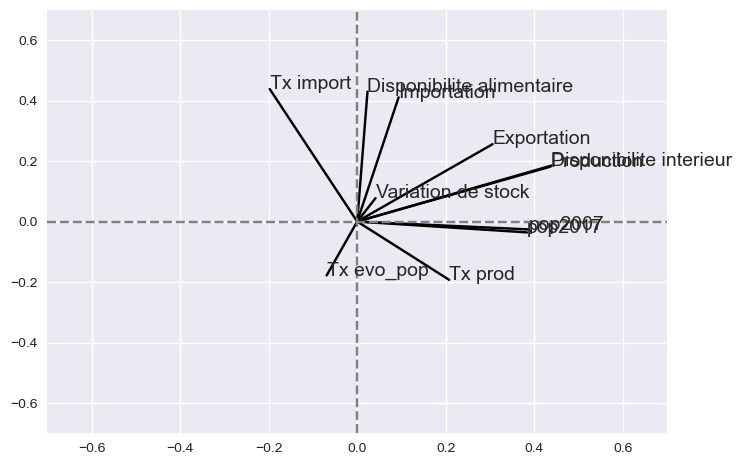

In [59]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    column_name = df2.columns[i]
    if column_name not in ["Groupe Pays", "kmeans"]:
        # Afficher un segment de l'origine au point (x, y)
        plt.plot([0, x], [0, y], color="k")
        # Afficher le nom de la performance
        plt.text(x, y, column_name, fontsize="14")

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color="grey", ls="--")

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color="grey", ls="--")

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

plt.show()

In [60]:
x = [col for col in df_acp.columns.tolist() if col not in ["Groupe Pays", "kmeans"]]

z = df_acp[x].corr()

hovercell = []
for yi, yy in enumerate(x):
    hovercell.append([])
    for xi, xx in enumerate(x):
        hovercell[-1].append("X: {}<br />Y: {}<br />Corr:{}".format(xx, yy, round(stats.pearsonr(df_acp[xx], df_acp[yy])[0], 2)))

map = [go.Heatmap(z=z, x=x, y=x,
                 xgap=1, ygap=1,
                 colorbar_thickness=20,
                 colorbar_ticklen=3,
                 hoverinfo='text',
                 text=hovercell)]

title = "Matrice de corrélation"

layout = go.Layout(
    title_text=title, title_x=0.5,
    width=950, height=800,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange="reversed"
)

fig = go.Figure(data=map, layout=layout)
iplot(fig, filename="pandas-heatmap")

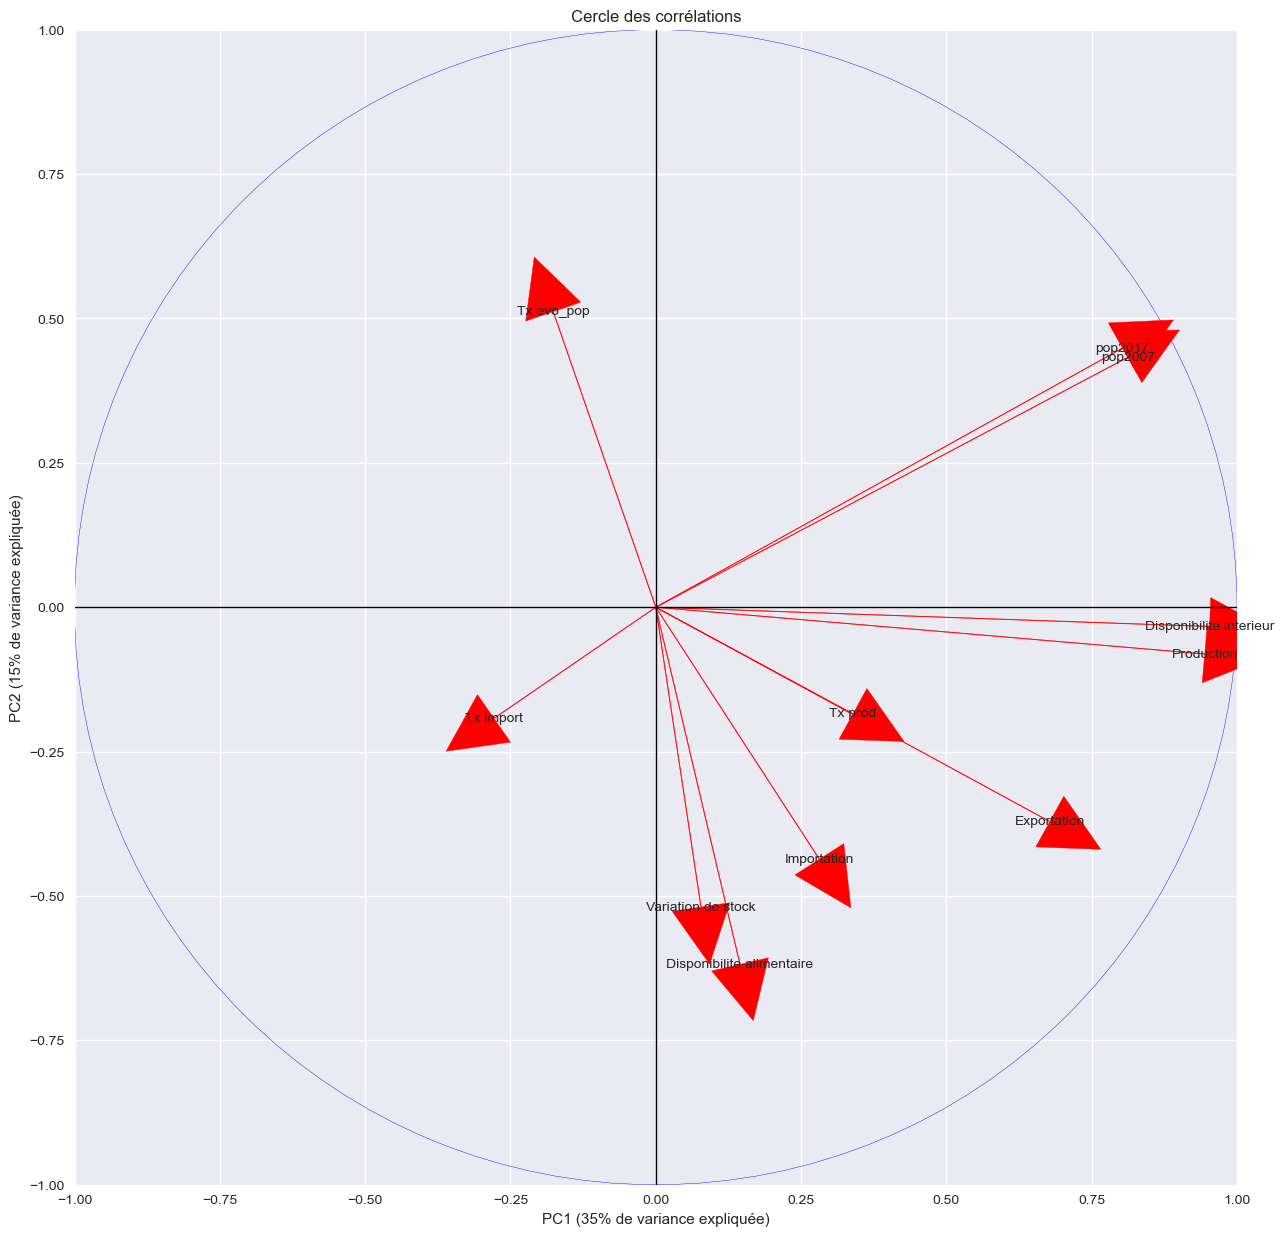

In [61]:
# Réalisation de l'analyse en composantes principales (PCA)
pca = PCA(n_components=2)
pca.fit(df_scaled2)

# Calcul des coordonnées des variables sur les composantes principales
variable_coordinates = pca.components_.T * np.sqrt(pca.explained_variance_)

# Création du cercle des corrélations
fig, ax = plt.subplots(figsize=(15, 15))
circle = plt.Circle((0, 0), 1, facecolor="none", edgecolor="b")
plt.gca().add_artist(circle)

# Affichage de la ligne de haut en bas
ax.plot([-1, 1], [0, 0], color='black', linestyle='-', linewidth=1)

# Affichage de la ligne de droite à gauche
ax.plot([0, 0], [-1, 1], color='black', linestyle='-', linewidth=1)

for i, (x, y) in enumerate(variable_coordinates):
    ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, fc='r', ec='r')
    ax.text(x, y, df3.columns[i], ha='center', va='center')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("PC1 ({}% de variance expliquée)".format(int(pca.explained_variance_ratio_[0] * 100)))
ax.set_ylabel("PC2 ({}% de variance expliquée)".format(int(pca.explained_variance_ratio_[1] * 100)))
ax.set_title("Cercle des corrélations")

plt.show()

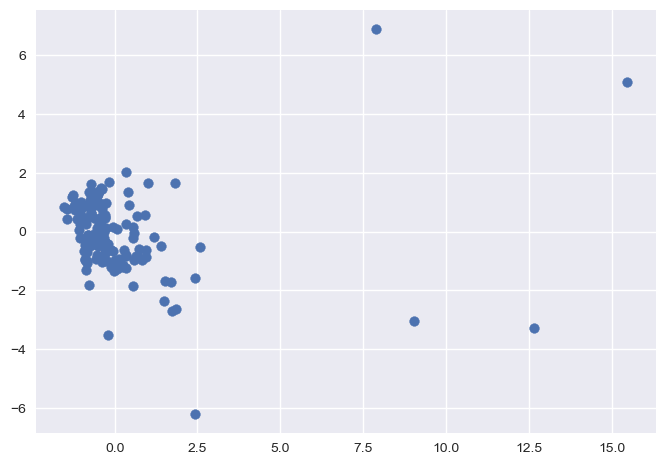

In [62]:
# projeter X sur les composantes principales
X_projected = pca.transform(df_scaled2)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1])

In [63]:
"""Les valeurs sont en grande partie normalisées (centrées et réduites) puisqu'elles sont proches de zéro."""

"Les valeurs sont en grande partie normalisées (centrées et réduites) puisqu'elles sont proches de zéro."

## Conclusion

In [64]:
# Liste des pays à afficher
pays_retenu = ["Allemagne", "Afrique du Sud", "Arabie Saoudite", "Mexique", "Hong-Kong", "Royaume-Uni"]

# Carte centrée sur les coordonnées
map_world = folium.Map(location=[0, 0], zoom_start=2)

# Tuiles (tiles layer) pour afficher les fonds de carte
folium.TileLayer('cartodbpositron').add_to(map_world)

# Géocodeur pour obtenir les coordonnées géographiques
geolocator = Nominatim(user_agent="my_app")

# Liste avec marqueurs pour chaque pays
for country in pays_retenu:
    # Coordonnées géographiques du pays
    location = geolocator.geocode(country)
    
    if location:
        # Coordonnées géographiques pour positionner le marqueur
        latitude = location.latitude
        longitude = location.longitude
        
        # Couleur du marqueur en fonction du pays
        if country == "Allemagne":
            color = "green"
        elif country == "Afrique du Sud":
            color = "blue"
        elif country == "Arabie Saoudite":
            color = "blue"
        elif country == "Mexique":
            color = "blue"
        elif country == "Hong-Kong":
            color = "blue"
        elif country == "Royaume-Uni":
            color = "orange" # La couleur "yellow" semble ne pas être reconnu
        
        # Marqueur pour chaque pays avec la couleur appropriée
        folium.Marker(location=[latitude, longitude], popup=country, icon=folium.Icon(color=color)).add_to(map_world)

# Afficher la carte
map_world

In [65]:
# Liste des bibliothèques importées
libraries = [module_name for module_name in sys.modules.keys() if 'IPython' not in module_name and 'google.colab' not in module_name]

# Nombre de bibliothèques
nombre_bibliotheques = len(libraries)
print("Nombre de bibliothèques : ", nombre_bibliotheques)

# Liste des variables définies dans l'espace de travail
variables = list(globals().keys())

# Nombre de variables
nombre_variables = len(variables)
print("Nombre de variables : ", nombre_variables)

# Nombre de séries
nombre_series = sum([isinstance(globals()[variable], pd.Series) for variable in variables if variable != 'variables'])
print("Nombre de séries : ", nombre_series)

Nombre de bibliothèques :  3770
Nombre de variables :  266
Nombre de séries :  3
